## 식사 인원 예측
### 아이디어
* 식사 인원의 수에 영향을 줄 수 있는 요소들은 다양하게 존재한다.<br>
* 가장 먼저 생각 할 수 있는 것들은, 메뉴, 날짜, 요일 정도라고 생각한다.<br>
* 그 중에서도 본인은 메뉴에 집중해서 데이터 처리를 진행 해 보고자 한다.<br>
* 전체 과정은 아래의 단계를 통해 진행되도록 한다.<br>

### 진행과정
1. 각 요일별 중식계, 석식계를 확인한다.<br>
2. 전체 인원 대바 몇 %의 인원이 식사를 했는지 비율을 구한다.<br>
3. 가장 식사 비율이 높은 날들의 메뉴를 확인한다.<br>
4. 메뉴 데이터를 계산하기 편하게 정리한다.<br>
5. 메인 메뉴라고 생각되는 메뉴들에서 키워드를 선별한다.<br>
6. 이 키워드 정보를 이용해 식사율 과의 상관관계를 파악해 본다.<br>

* 전체 데이터의 결과에 메뉴가 주는 영향이 클 수도 있고, 그렇지 않을 수도 있지만 한 번 시도 해 볼 만한 방식이라고 생각 된다.

### 데이터 불러오기

In [177]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['font.family'] = 'NanumGothic'

In [178]:
train = pd.read_csv(os.getenv("HOME")+"/aiffel/dacon/train.csv")
test = pd.read_csv(os.getenv("HOME")+"/aiffel/dacon/test.csv")
submission = data = pd.read_csv(os.getenv("HOME")+"/aiffel/dacon/sample_submission.csv")

In [179]:
# 데이터 정보 확인
train.describe(include='O')

,일자,요일,조식메뉴,중식메뉴,석식메뉴
count,1205,1205,1205,1205,1205
unique,1205,5,1204,1198,1168
top,2016-02-04,목,모닝롤/프렌치토스트 우유/주스 계란후라이 누룽지탕/쌀밥 (쌀:국내산) 무채국 김...,쌀밥/잡곡밥 (쌀:국내산) 차돌된장찌개 주꾸미볶음 옥수수전 양념깻잎지 포기김...,*
freq,1,244,2,2,19


* 목요일이 가장 많고, 조식, 중식, 석식이 모두 포함 되있으며, 석식은 중복되는 메뉴가 좀 있는편이다.

In [180]:
# 데이터 크기 확인
train.shape

(1205, 12)

### 전처리 시작

In [181]:
# 조식메뉴 삭제
train.drop(['조식메뉴'], axis=1, inplace=True)
test.drop(['조식메뉴'], axis=1, inplace=True)

* submission 이 중식, 석식에 관한 내용이므로 조식메뉴 삭제

In [182]:
# 년, 월, 일 추출
train['년도'] = pd.to_datetime(train['일자']).dt.year
train['월'] = pd.to_datetime(train['일자']).dt.month
train['일'] = pd.to_datetime(train['일자']).dt.day

test['년도'] = pd.to_datetime(test['일자']).dt.year
test['월'] = pd.to_datetime(test['일자']).dt.month
test['일'] = pd.to_datetime(test['일자']).dt.day

* 추후에 사용하기 위해 년, 월, 일 정보를 별도의 column으로 추가

In [183]:
# 결과 확인
train.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일
0,2016-02-01,월,2601,50,150,238,0.0,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2016,2,1


#### 메뉴 전처리 (윤세휘님 코드 참조)

In [184]:
import re

# 괄호 안의 원산지 데이터 제거, 코드 수정 예정

def split_menu(df):
    
    # direct replacement
    for i in range(len(df)):
        df.iloc[i] = re.sub(r"\([^\)]+\)", "", df.iloc[i])      # 소괄호부분 제거
        df.iloc[i] = df.iloc[i].replace('(New)', '').replace('  ', ' ').strip().split(' ')  # 공백처리 후 문자열 분리
        
#         if len(list) == 8:
#             print()
#             print(list)

split_menu(train['중식메뉴'])
split_menu(train['석식메뉴'])
split_menu(test['중식메뉴'])
split_menu(test['석식메뉴'])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


* 각 메뉴를 정돈 된 형태로 수정한다.
1. '()' 포함, 내부의 정보 삭제
2. 공백의 수 일정화
3. '(New)' 등의 불필요한 문자 제거
4. 리스트의 형태로 저장

In [185]:
# 결과 확인
train.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일
0,2016-02-01,월,2601,50,150,238,0.0,"[쌀밥/잡곡밥, 오징어찌개, 쇠불고기, 계란찜, 청포묵무침, 요구르트, 포기김치]","[쌀밥/잡곡밥, 육개장, 자반고등어구이, 두부조림, 건파래무침, 포기김치]",1039.0,331.0,2016,2,1


#### 식사 인원의 비율 계산

In [186]:
# 전체 출근인원대비 중식계, 석식계 비율 추가
train['중식계비율'] = train['중식계'] / (train['본사정원수'] - train['본사휴가자수'] - train['본사출장자수'] - train['현본사소속재택근무자수'])
train['석식계비율'] = train['석식계'] / (train['본사정원수'] - train['본사휴가자수'] - train['본사출장자수'] - train['현본사소속재택근무자수'])

* 전체 출근 인원 대비 식사 인원의 비율을 구하기 위해 본사정원수에서 휴가자, 출장자, 재택근무자 등을 제외하고 난 인원 대비 식사 인원의 비율을 계산

In [187]:
# 확인
train.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일,중식계비율,석식계비율
0,2016-02-01,월,2601,50,150,238,0.0,"[쌀밥/잡곡밥, 오징어찌개, 쇠불고기, 계란찜, 청포묵무침, 요구르트, 포기김치]","[쌀밥/잡곡밥, 육개장, 자반고등어구이, 두부조림, 건파래무침, 포기김치]",1039.0,331.0,2016,2,1,0.432736,0.137859


### 인기 메뉴 선별
1) 중식계비율, 석식계비율이 높은 날의 메뉴일 수록 인기메뉴라고 볼 수 있다.<br>
2) 인기메뉴 중, 메인메뉴에 대한 키워드를 선별하여 별도로 저장한다.<br>
3) 각 날짜별 메뉴 정보를 가져와 선별된 키워드를 몇개나 포함하는 지 여부를 확인한다.<br>
4) 키워드와 식사율 간의 상관관계를 확인한다.

#### 중식계 비율 계산

In [188]:
# 중식계 비율이 가장 높은 날
train.loc[train['중식계비율'] == train['중식계비율'].max()]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일,중식계비율,석식계비율
1170,2020-12-01,화,2990,204,161,878,408.0,"[쌀밥/찰보리밥/찰현미밥, 김치두부국, LA갈비구이, 한식잡채, 삼색유자청무침, 포...","[마파두부, 홍합짬뽕국, 샤워크림새우, 물만두찜*장, 짜사이볶음, 백김치]",1324.0,685.0,2020,12,1,0.597203,0.308976


* 중식계비율(점심을 먹은 사람)의 최대치는 60% 정도 된다.

In [191]:
# 중식계 비율이 가장 낮은 날
train.loc[train['중식계비율'] == train['중식계비율'].min()]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일,중식계비율,석식계비율
469,2017-12-28,목,2665,240,260,55,0.0,"[쌀밥/잡곡밥, 아욱된장국, 돼지갈비찜, 콩나물겨자채, 참나물무침, 포기김치]","[쌀밥/잡곡밥, 옛날왕돈까스, 크림스프, 감자범벅/오이피클, 과일샐러드, 알타리김치]",311.0,245.0,2017,12,28,0.143649,0.113164


* 중식계 비율이 가장 낮은 날을 보니 메뉴보다는 연말이라는 점이 더 중요하게 작용하는 것 처럼 보인다.

In [192]:
# 비율 0.2 이하 확인
train.loc[train['중식계비율'] < 0.2]

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일,중식계비율,석식계비율
469,2017-12-28,목,2665,240,260,55,0.0,"[쌀밥/잡곡밥, 아욱된장국, 돼지갈비찜, 콩나물겨자채, 참나물무침, 포기김치]","[쌀밥/잡곡밥, 옛날왕돈까스, 크림스프, 감자범벅/오이피클, 과일샐러드, 알타리김치]",311.0,245.0,2017,12,28,0.143649,0.113164
645,2018-09-14,금,2763,174,313,132,0.0,"[쌀밥/잡곡밥, 고추장찌개, 언양식불고기, 계란말이, 상추파무침, 포기김치]","[쌀밥/잡곡밥, 도토리묵냉국, 해물누룽지탕, 동그랑땡전, 도라지무침, 포기김치]",405.0,375.0,2018,9,14,0.177944,0.164763
704,2018-12-21,금,2846,175,261,163,0.0,"[쌀밥/잡곡밥, 닭개장, 갈치양념조림, 고기전, 비트무생채, 포기김치]","[쌀밥/잡곡밥, 쇠고기미역국, 생선까스*탈탈소스, 마파두부, 콩나물무침, 포기김치]",456.0,456.0,2018,12,21,0.189212,0.189212
705,2018-12-24,월,2846,894,159,26,0.0,"[쌀밥/잡곡밥, 열무된장국, 훈제오리구이, 매운어묵볶음, 쌈무/부추생채, 크리스마스...","[쌀밥/잡곡밥, 민물새우찌개, 닭갈비, 버섯잡채, 오이무침, 포기김치]",296.0,104.0,2018,12,24,0.165086,0.058003
801,2019-05-17,금,2825,224,291,1,0.0,"[쌀밥/잡곡밥, 버섯매운탕, 탕수어, 온두부, 치커리유자청무침, 볶음김치]","[쌀밥/잡곡밥, 닭개장, 미니함박조림, 브로컬리오징어숙회, 아삭고추무침, 포기김치]",408.0,362.0,2019,5,17,0.176623,0.156710
855,2019-08-02,금,3305,687,237,2,0.0,"[쌀밥/잡곡밥, 고추장찌개, 미트볼케찹조림, 계란말이, 꽈리고추찜, 포기김치]","[쌀밥/잡곡밥, 매운버섯국, 고등어구이, 두부스테이크, 참나물생채, 포기김치]",440.0,274.0,2019,8,2,0.184796,0.115078
949,2019-12-20,금,3111,337,261,4,0.0,"[쌀밥/잡곡밥, 감자양파국, 매운닭찜, 두부커틀릿, 간장깻잎지, 포기김치]","[쌀밥/잡곡밥, 부대찌개, 오징어볶음*소면, 계란찜, 모듬묵*장, 포기김치]",481.0,353.0,2019,12,20,0.191405,0.140470
951,2019-12-24,화,3111,478,216,52,0.0,"[쌀밥/잡곡밥, 오징어국, 치킨핑거, 애호박전, 콩나물무침, 조각케익, 포기김치]","[굴소스볶음밥, 토마토스파게티, 크림스프, 마늘빵/감자튀김, 수제오이피클, 요구르트...",462.0,221.0,2019,12,24,0.191146,0.091436
953,2019-12-27,금,3111,706,236,1,0.0,"[파인애플볶음밥, 가쯔오장국, 사천식탕수육, 콘치즈오븐구이, 단무지무침, 포기김치]","[쌀밥/잡곡밥, 매운버섯국, 굴비구이, 버섯잡채, 아삭고추무침, 배추겉절이]",387.0,226.0,2019,12,27,0.178423,0.104195
955,2019-12-31,화,3111,709,149,22,0.0,"[쌀밥/잡곡밥, 배추된장국, 닭볶음탕, 부추깻잎전, 양배추쌈*쌈장, 포기김치]",[*],349.0,0.0,2019,12,31,0.154905,0.000000


* 비율이 0.2 이하인 날들을 확인 해 보니 대부분 연말이거나 금요일이라는 것을 알 수 있다.
* 따라서 날짜에 따라 많은 영향을 받을 것 같다는 사실을 다시 확인 할 수 있다.
* 하지만 역시 메뉴에 따른 영향도 어느정도 있을 것이라 생각되어 계속 진행해보기로 한다.

In [14]:
# 출근인원의 절반이상이 중식을 먹은 경우를 인기메뉴로 결정 할까?
pop_l_menu = train.loc[train['중식계비율'] >= 0.50]

* 절반이상(50% 이상)의 사람이 중식을 먹은 날은 전체 중 120일이다.
* 일단 50%로 설정을 한 뒤, 추후 진행 상황에 따라 55% 이상으로 설정을 변경할 필요가 있을수도 있다.

### 인기 메뉴 키워드 선별

In [194]:
# 중식계 비율이 가장 높은 120일의 메뉴 출력
for i in pop_l_menu['중식메뉴']:
    print(i)

['쌀밥/잡곡밥', '시래기국', '훈제오리구이', '도토리묵무침', '쌈무/양파절임', '요구르트', '포기김치']
['쌀밥/잡곡밥', '시금치국', '닭감자조림', '연두부*양념장', '콩나물무침', '요구르트', '포기김치']
['쌀밥/오곡밥', '쇠고기느타리국', '갈치구이', '호박꼬지&고사리&무나물', '파래김*양념장', '부럼/요구르트', '포기김치']
['쌀밥/잡곡밥', '콩나물국', '닭갈비', '모둠묵*양념장', '톳두부무침', '포기김치']
['쌀밥/잡곡밥', '어묵국', '돈육고추장볶음', '모둠양채쌈*쌈장', '콩나물파채무침', '', '포기김치']
['쌀밥/잡곡밥', '얼갈이된장국', '닭갈비', '해파리냉채', '취나물', '포기김치']
['쌀밥/잡곡밥', '순두부찌개', '쇠불고기', '브로컬리맛살볶음', '풋마늘초무침', '포기김치']
['쌀밥/잡곡밥', '시래기국', '훈제오리구이', '무쌈/양파절임', '풋마늘초무침', '포기김치']
['쌀밥/잡곡밥', '콩나물국', '돈간장불고기', '김치전', '버섯볶음', '포기김치']
['쌀밥/잡곡밥', '시금치국', '닭갈비', '맛살겨자채', '비름나물', '포기김치']
['쌀밥/잡곡밥', '매운어묵국', '훈제오리구이', '무쌈/양파절임', '도토리묵무침', '포기김치']
['쌀밥/잡곡밥', '감자고추장찌개', '돈육굴소스볶음', '계란찜', '꽃상추무침', '포기김치']
['쌀밥/잡곡밥', '콩나물김치국', '누룽지탕수육', '명태조림', '오이도라지생채', '포기김치']
['쌀밥/잡곡밥', '북어계란국', '돈육굴소스볶음', '홍어채무침', '가지나물', '포기김치']
['쌀밥/잡곡밥', '북어콩나물국', '제육볶음', '참치야채전', '모둠쌈', '포기김치']
['쌀밥/잡곡밥', '어묵국', '레몬탕수육', '명태엿장조림', '시금치나물', '포기김치']
['쌀밥/잡곡밥', '감자고추장찌개', '버섯불고기', '맛살겨자초무침', '노각무침', '포기김치']
['쌀밥/잡곡밥',

In [193]:
# 메인 메뉴의 키워드
popular = ['찌개', '감자채전', '동그랑땡', '동파육', '치즈', '육계장', '파스타',
           '골뱅이', '강정', '계란말이', '류산슬', '김치전', '오꼬노미야끼', 
           '꽃게탕', '해물', '계란찜', '짬뽕', '굴', '쌈장', '구이', '돈까스', 
           '카레', '치킨', '춘권', '궁보계정', '두루치기', '장조림', '바지락', 
           '쇠고기', '차돌', '쭈꾸미', '소세지', '갈치', '요구르트', '불고기', 
           '제육', '갈비', '돈육', '오리', '소고기', '어묵', '오징어', '닭', 
           '샐러드', '삼겹살', '잡채', '돼지', '요거트', '백숙', '쫄면', '불낙', 
           '춘권', '두루치기', '만두', '족발', '골뱅이', '탕수육', '강정', '낙지']

#### 전체 메뉴에 대한 인기키워드 검색

In [18]:
pop_freq = [] # 인기 키워드가 포함된 횟수 저장
idx = 0

for i in range(len(train['중식메뉴'])):
    cnt = 0
    tmp_menu = ' '.join(train['중식메뉴'].iloc[i]) # 메뉴를 하나씩 가져와서
    
    for j in popular: # 인기 키워드를 포함하면
        cnt = cnt + tmp_menu.count(j) # 카운트를 추가한다.
    pop_freq.append(cnt) # 측정된 카운트를 리스트에 저장
    idx += 1 # 다음메뉴로 넘어간다.

pop_freq

[5,
 4,
 4,
 2,
 5,
 3,
 4,
 2,
 3,
 4,
 5,
 4,
 4,
 3,
 2,
 4,
 3,
 2,
 2,
 2,
 1,
 2,
 4,
 2,
 3,
 1,
 3,
 3,
 1,
 0,
 2,
 3,
 3,
 2,
 3,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 1,
 2,
 2,
 2,
 2,
 4,
 1,
 1,
 1,
 1,
 2,
 3,
 1,
 3,
 4,
 2,
 1,
 2,
 3,
 2,
 3,
 3,
 4,
 4,
 0,
 1,
 3,
 3,
 2,
 2,
 1,
 3,
 2,
 1,
 3,
 2,
 2,
 4,
 2,
 1,
 2,
 3,
 1,
 2,
 3,
 1,
 6,
 3,
 3,
 0,
 2,
 3,
 2,
 2,
 3,
 4,
 3,
 2,
 3,
 5,
 4,
 1,
 4,
 1,
 2,
 0,
 2,
 4,
 0,
 2,
 2,
 4,
 2,
 3,
 0,
 3,
 1,
 4,
 1,
 1,
 1,
 4,
 2,
 1,
 3,
 3,
 1,
 1,
 1,
 0,
 1,
 3,
 1,
 3,
 0,
 3,
 4,
 2,
 3,
 2,
 2,
 2,
 2,
 4,
 3,
 0,
 2,
 3,
 3,
 1,
 1,
 1,
 2,
 3,
 2,
 3,
 3,
 1,
 3,
 4,
 2,
 1,
 3,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 0,
 2,
 3,
 3,
 1,
 3,
 1,
 1,
 2,
 1,
 3,
 3,
 3,
 4,
 2,
 3,
 1,
 3,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 4,
 3,
 1,
 3,
 3,
 1,
 3,
 2,
 2,
 2,
 3,
 3,
 5,
 2,
 3,
 3,
 2,
 1,
 2,
 3,
 1,
 4,
 3,
 1,
 2,
 3,
 3,
 1,
 1,
 2,
 3,
 1,
 1,
 1,
 3,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 3,
 2,


* 키워드들이 저장된 리스트를 만들고 결과를 확인 해 봤다.

#### train set에 인기키워드 column 추가

In [196]:
train = pd.concat([train, pd.Series(pop_freq, name='인기키워드')], axis=1)

In [198]:
train.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일,중식계비율,석식계비율,인기키워드
0,2016-02-01,월,2601,50,150,238,0.0,"[쌀밥/잡곡밥, 오징어찌개, 쇠불고기, 계란찜, 청포묵무침, 요구르트, 포기김치]","[쌀밥/잡곡밥, 육개장, 자반고등어구이, 두부조림, 건파래무침, 포기김치]",1039.0,331.0,2016,2,1,0.432736,0.137859,5


In [199]:
train.tail(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,중식메뉴,석식메뉴,중식계,석식계,년도,월,일,중식계비율,석식계비율,인기키워드
1204,2021-01-26,화,2983,69,183,551,362.0,"[쌀밥/귀리밥/찰현미밥, 들깨미역국, 교촌간장치킨, 옥수수콘치즈구이, 가지고추장무침...","[할라피뇨멸치주먹밥, 잔치국수, 수제고기육전, 쑥갓나물, 양파초절임, 깍두기]",1015.0,480.0,2021,1,26,0.428451,0.202617,5


#### 인기 키워드의 수에 따른 인기여부 확인
1. 키워드 개수에 따라 popular, normal, bad 세 가지로 분리 한다.<br>
2. 각각의 평균을 구한다.<br>
3. 그래프를 통해 확인한다.

In [204]:
train_pop = train.loc[train['인기키워드'] >= 5] # 키워드 개수 5개 이상 : 인기가 많다.
train_nor = train.loc[(train['인기키워드'] <= 4) & (train['인기키워드'] >= 2)] # 2~4개 : 보통
train_bad = train.loc[(train['인기키워드'] == 1) | (train['인기키워드'] == 0)] # 0~1개 : 인기가 없다.

* 먼저 키워드 개수별로 그룹을 나누고

In [205]:
train_nor.shape

(865, 17)

In [206]:
train_pop.shape

(66, 17)

In [207]:
train_bad.shape

(274, 17)

* 각 그룹에 몇 개씩 포함되어있는지 확인한다.

In [208]:
# 각 메뉴에 대한 중식계 비율의 평균을 구한다.
pop_day_ratio = train_pop['중식계비율'].mean()
nor_day_ratio = train_nor['중식계비율'].mean()
bad_day_ratio = train_bad['중식계비율'].mean()

* 그 다음 각 그룹의 평균을 구해서

In [113]:
pop_day_ratio = round(pop_day_ratio, 2)
pop_day_ratio

0.42

In [114]:
nor_day_ratio = round(nor_day_ratio, 2)
nor_day_ratio

0.38

In [116]:
bad_day_ratio = round(bad_day_ratio, 2)
bad_day_ratio

0.37

* 소수 둘째자리까지 출력하여 확인 해 본 다음

In [209]:
# 각 그룹에 대한 중식계 비율을 dataframe으로 저장
pop_ratio = pd.DataFrame({'많음': pop_day_ratio, '보통': nor_day_ratio, '적음': bad_day_ratio}, index=['중식계비율'])
pop_ratio

,많음,보통,적음
중식계비율,0.417576,0.376626,0.366023


* 각 그룹의 중식계비율 평균값을 dataframe으로 저장한다.

### barplot을 이용한 시각화 비교

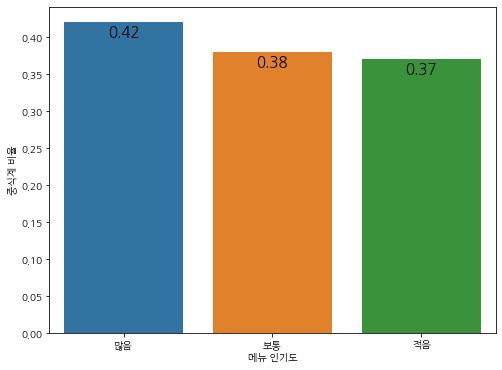

In [157]:
index = np.arange(0, 0.5, 0.05)
plt.figure(figsize = (8, 6))
plots = sns.barplot(data=pop_ratio)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, -10),
                   textcoords='offset points')    
plt.xlabel("메뉴 인기도")
plt.ylabel("중식계 비율")
plt.show()

* 마지막으로 그래프로 나타내어 결과를 비교해 본다.

### 결론

* 결과적으로 메뉴가 주는 영향이 없다고 볼 수 는 없지만 그 영향이 상당하다고 할 수 도 없다.
* 위 단계를 진행하며 알게 된 몇가지 문제점들을 적어보자면
1. 연말, 금요일 등의 특수 요일들의 경우 메뉴에 상관없이 식사 인원이 결정되는 경향이 있다. 이런 데이터들은 메뉴를 중점으로 데이터를 보고자 한 이번 시도에서 outlier처럼 작동하여 데이터의 일관성을 해치는 작용을 한다. 중식계 비율이 0.2 이하인 데이터들이 대부분 금요일 또는 연말이라는 것을 통해 이 사실을 확인 할 수 있고, 따라서 이 데이터들을 별도로 분리하여 처리하는 것이 좀 더 올바른 방식이라고 생각한다.
2. 인기 메뉴의 키워드를 선정함에 있어서 특별한 기준이 없이 일반적으로 통용되는 사실에 따라 진행 하였기에 신뢰도가 높지 않다. 이를 보완할 수 있는 방식은 실제 이 모델을 적용하고자 하는 곳에서 인기 메뉴에 대한 설문을 조사 한 뒤에 그 메뉴들의 정보를 토대로 진행하면 좀 더 정확도가 높은 모델이 될 것 이라 생각한다.
3. 만약 여러가지 메뉴들이 번갈아가면서 반복적으로 사용되는 구조라면 인기 키워드 대신 메뉴 자체를 기준으로 인기도를 계산 하는 것이 더 정확할 것 같다.
* 이상의 문제점들을 개선되면 좀 더 명확한 결과를 얻을 수 있을 것이라 생각한다.
* 최종적으로 우리가 원하는 인원수를 예상하기 위해서는 기존의 식사 인원의 비율을 계산하고 이를 모델에 학습시킨다음 계산된 비율을 이용해 역으로 인원수를 예상하는 방식으로 진행 할 수 있을 것이다.